# Vacancies
####by Omar A. Guerrero, University of Oxford
We continue following Pissarides' framework by specifying the behavior of firms. Firms employ an allocation rule for an optimal vacancy rate (see Pissarides' book chapter 1.2). We do this for each firm in order to build the capability of firm heterogeneity.

## Libraries
We employ a new library: bisect. Bisect will help us manipulating lists in order to select sub-groups of agents.

In [9]:
from __future__ import division # forces a division of integers to return a float (in order to avoid errors)
%matplotlib inline
import random as rd # tools to genrate random numbers and more
import matplotlib.pyplot as plt # we will use this to visualize the model's output
import bisect # a library to slice lists

## Parameters
We remove the market tightness $\theta$ and introduce a cost $c$ associated with keeping an unfilled job position open and there is a discount factor $r$ involved in the inter-temporal decisions of the firm.

In [10]:
L = 1000 # number of workers
N = 100 # number of firms
Lambda = 0.08 # the exogenous source of unemployment, also known as the separation rate
w = .65 # the wage generated (we will assume it to be fixed)
Alpha = .5 # a parameter of the aggregate matching function, explained in the Market section
c = 0.6 # the cost of holding an unfilled vacancy
y = 1.0 # productivity of a filled vacancy
r = 0.95 # dicount factor
max_t = 500 # maximum number of steps to be ran in the simulation

## Agents

### Workers
We update the step() method to ask the stats agent for the total number of vacancies in the economy.

In [11]:
class Worker():
    
    # gives birth (initializes) to a single worker
    def __init__(self, id, Lambda=Lambda, w=w, employer=None):
        self.id = id # the id of the worker
        self.Lambda = Lambda # the separation rate of the worker
        self.w = w # the wage of the worker
        self.employer = employer # the firm for which the agent works
    
    # checks if the agent works for a firm and returns False if she is unemployed and True otherwise
    def is_employed(self):
        return not self.employer==None
    
    # register hiring
    def hired(self, firm, wage, t):
        self.employer = firm
        self.w = wage
        self.last_period = t
    
    # register separation
    def separated(self, t):
        self.employer = None
        self.w = 0
        self.last_period = t
        
    # specifies what the agent does in each step of the simulation
    def step(self, t):
        rand = rd.random() # draw a random number
        if self.is_employed(): # check employment status
            # the probability of becoming unemployed is the average of the separation rates of the worker and the firm.
            # This is a bit of an arbitrary assumption but can be modified later. The point is to capture the effect
            # that each counterpart has in the process of unemployment. Since we will assume homogenous agents, this
            # specification does not change from simply assuming the general Lambda to be the only source of unemployment.
            if rand < (self.Lambda + self.employer.Lambda)/2:
                market.separation(self, t) # peform separation in the market
        else:
            if rand < market.matching_proba(): # check if the labor market frictions allow the match
                firm = market.pick_firm() # pick a firm at random
                wage = w # determine the wage
                market.hiring(self, firm, wage, t) # perform the hiring in the market

### Firms
It is time to fill-in the step() method of the firm. In Pissarides' world, firms maximize their lifetime value of a filled job which leads to the optimality condition $y-w = \frac{(r+\lambda)yc}{M/V}$. We can solve this condition to obtain the number of vacancies $V$ in the economy, which divided by $N$ yields the contribution of the individual firm: $V_i = \frac{M(y-w)}{Ncy(\lambda+r)}$. This, of course, assumes that the firm knows the vacancies that all other firms are opening, and that all other firms are identical, hence, they open the same number of vacancies (otherwise we would not be in equilibrium).

In [12]:
class Firm():
    
    # initializes the firm
    def __init__(self, id, Lambda=Lambda, c=c, y=y, r=r):
        self.id = id
        self.Lambda = Lambda
        self.c = c
        self.y = y
        self.r = r
        self.V = 1 # the number of vacancies 
        self.book = {}
    
    # register a newly hired worker with her wage and the period of hiring
    def hire(self, worker, wage, t):
        self.book[worker] = (wage, t)
    
    # remove the separated worker from the book
    def separate(self, worker):
        self.book.pop(worker)
    
    # compute the size (in number of employees)
    def size(self):
        return len(self.book)
    
    def open_vacancies(self):
        U = stats.data['U']
        M = stats.data['M']
        self.V = M*(self.y-w)/(N*self.c*self.y*(self.Lambda+self.r))
    
    # specifies what the firm does in each step of the simulation
    def step(self, t):
        self.open_vacancies()

### Market
We update the matching function to consider the number of vacancies instead of the market tightness. We also modify the method for picking a firm at random. Since each firm has its own level of $V_i$, we have built in capability for heterogeneity. If a firm has a higher $V_i$ than the others, it that should be reflected in its number of matches. The new method accounts for this by selecting a firm at random, with a probability proportional to its $V_i$. In order to perform this, we will need to provide the market with the init() method so that it stores the list of probabilities associated to the $V_i$ of each firm, and a step() method to update them every period.

In [13]:
class Market():
    
    # initializes the market
    def __init__(self):
        self.pVs = [1/N for firm in firms]
        self.cVs = [sum(self.pVs[:x]) for x in range(1,len(self.pVs)+1)]
    
    # register a hiring in both the firm and the worker attributes
    def hiring(self, worker, firm, wage, t):
        worker.hired(firm, wage, t)
        firm.hire(worker, wage, t)
    
    # register a separation in both the firm and the worker attributes
    def separation(self, worker, t):
        worker.employer.separate(worker)
        worker.separated(t)
    
    # the aggregate matching function
    def matches(self, U=1, V=1):
        return Alpha*U + (1-Alpha)*V
    
    # the probability of a match
    def matching_proba(self):
        U = stats.data['U']
        V = stats.data['V']
        return self.matches(U, V)/U
    
    # update vacancies
    def update_vacancies(self):
        self.pVs = [V/stats.data['V'] for V in stats.data['Vs']]
        self.cVs = [sum(self.pVs[:x]) for x in range(1,len(self.pVs)+1)]
    
    # pick a firm at random
    def pick_firm(self):
        return firms[bisect.bisect_right(self.cVs, rd.random())]
    
    # updates every period
    def step(self):
        self.update_vacancies()

### Statistics Bureau
We add a method for counting the total number of vacancies and keep track of it through time. We also update the theoretical predicitons. Now we have a prediction for the unemployment rate and for the number of vacancies as well.

In [14]:
class Stats():
    
    # initializes the statistics bureau
    def __init__(self):
        self.data = {} # a dictionary that holds different data structures
        self.data['u'] = 1 # the latest unemployment rate
        self.data['U'] = 1 # the latest unemployment level
        self.data['V'] = 1 # the number of vacancies
        self.data['Vs'] = [1 for firm in firms]
        self.data['M'] = 1 # the latest number of matches
        self.data['ts_u'] = [] # list that stores the time series of the unemployment rate
        self.data['ts_v'] = [] # list that stores the time series of the vacancy rate
        
    # counts the number of employed
    def count_employed(self):
        return sum([worker.is_employed() for worker in workers])
    
    # counts the number of unemployed
    def count_unemployed(self):
        return sum([not worker.is_employed() for worker in workers])
    
    # counts the vacancies per firm
    def count_vacancies(self):
        return [firm.V for firm in firms]
    
    # counts the total vacancies
    def sum_vacancies(self):
        return sum(count_vacancies())
        
    # computes the unemployment rate
    def unemployment_rate(self):
        return self.count_unemployed()/L
    
    # computes the average wage
    def average_wage(self):
        return sum([worker.w for worker in workers if worker.is_employed()])/self.count_employed()
    
    # computes the average firm size
    def average_firm_size(self):
        return sum([firm.size() for firm in firms])/N
    
    # what the statistics bureau does every period
    def step(self):
        self.data['Vs'] = self.count_vacancies()
        self.data['V'] = sum(self.data['Vs'])
        self.data['U'] = self.count_unemployed()
        self.data['M'] = market.matches(self.data['U'], self.data['V'])
        self.data['u'] = self.data['U']/L
        self.data['ts_u'].append(self.data['u'])
        self.data['ts_v'].append(self.data['V']/L)
    
    # the theoretical unemployment rate from Pissarides' model
    def theory_u(self):
        return (Lambda*(w-w*Alpha+y*(-1+Alpha+c*(r+Lambda))))/(-(w-y)*(-1+Alpha)*Lambda+c*y*(r+Lambda)*(Alpha+Lambda))
    
    # the theoretical unemployment rate from Pissarides' model
    def theory_v(self):
        return ((w-y)*Alpha*Lambda)/((w-y)*(-1+Alpha)*Lambda-c*y*(r+Lambda)*(Alpha+Lambda))

## Execution

### Initialization

In [15]:
workers = [Worker(id) for id in range(L)] # list of workers parameterized acording to the Parameters section
firms = [Firm(id) for id in range(N)] # list of firms parameterized acording to the Parameters section
agents = workers + firms # make a joint list of workers and firms
rd.shuffle(agents) # randomize the order to the agents in the list
market = Market() # our market object
stats = Stats() # our statistics bureau

### Iteration

In [16]:
for t in range(max_t):
    [agent.step(t) for agent in agents]
    stats.step() # the stats agent perform its duty
    market.step()

## Plotting

### Unemployment Rate

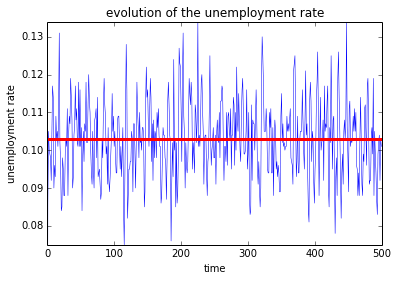

In [17]:
plt.plot(stats.data['ts_u'], linewidth=.5) # plot the time series collected by the stats agent
plt.plot([stats.theory_u() for i in range(max_t)], 'r', linewidth=3) # plot the analytical prediction
plt.ylim([min(stats.data['ts_u'][1::]), max(stats.data['ts_u'][1::])])
plt.xlabel('time')
plt.ylabel('unemployment rate')
plt.title('evolution of the unemployment rate')

###Vacancy Rate

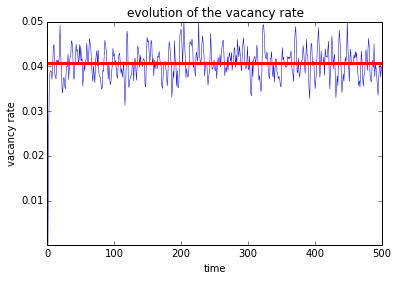

In [21]:
plt.plot(stats.data['ts_v'], linewidth=.5) # plot the time series collected by the stats agent
plt.plot([stats.theory_v() for i in range(max_t)], 'r', linewidth=3) # plot the analytical prediction
plt.ylim([min(stats.data['ts_v'][1::]), max(stats.data['ts_v'][1::])])
plt.xlabel('time')
plt.ylabel('vacancy rate')
plt.title('evolution of the vacancy rate')

### Firm Size Distribution

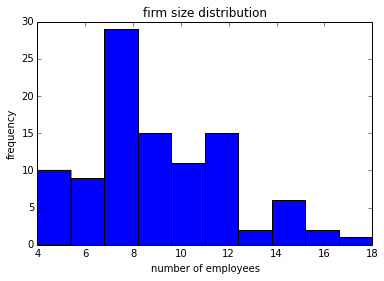

In [19]:
plt.hist([firm.size() for firm in firms]) # plot the time series collected by the stats agent
plt.xlabel('number of employees')
plt.ylabel('frequency')
plt.title('firm size distribution')

## Conclusion
We have expanded the to include vacancy formation in each firm from their optimization decisions. Firms do not know the form of the matching functions (as in Pissarides), but instead, they observe the latest information about the number of matches recorded by the stats bureau and use it with their private information about costs and productivity in order to determine their optimal $V_i$. This process converges to the rational expectations equilibrium since we assume that firms know the true parameters of the model ($\lambda_i=\lambda$). However, this might change later if we introduce heterogeneity that makes their beliefs inconsistent with the real world. The next step is to incorporate some behavior in our workers in order to generate wages endogenously.